In [ ]:
!pip install qiskit

QUANTUM BURGERS EQUATION SOLVER
Using Hydrodynamic Schrödinger Equation Formulation

Simulating with riemann initial condition...
Starting quantum Burgers simulation with 4 qubits
Grid points: 16, dx: 0.0625, dt: 0.0050
Initial state extraction failed: name 'AerSimulator' is not defined
Nonlinear potential failed: 'QuantumCircuit' object has no attribute 'czz'
Step 1/30, t=0.0050, max_u=2.9136
Nonlinear potential failed: 'QuantumCircuit' object has no attribute 'czz'
Nonlinear potential failed: 'QuantumCircuit' object has no attribute 'czz'
Nonlinear potential failed: 'QuantumCircuit' object has no attribute 'czz'
Nonlinear potential failed: 'QuantumCircuit' object has no attribute 'czz'
Nonlinear potential failed: 'QuantumCircuit' object has no attribute 'czz'
Step 6/30, t=0.0300, max_u=3.0125
Nonlinear potential failed: 'QuantumCircuit' object has no attribute 'czz'
Nonlinear potential failed: 'QuantumCircuit' object has no attribute 'czz'
Nonlinear potential failed: 'QuantumCircuit'

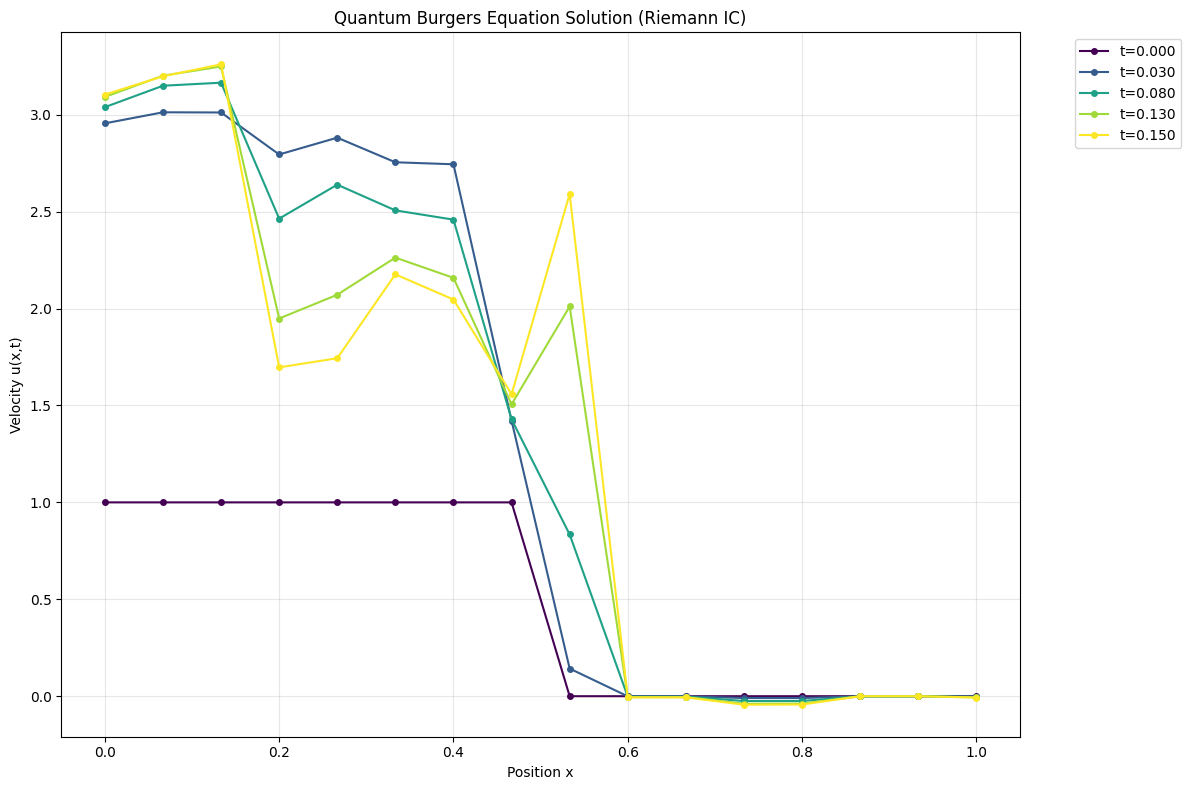

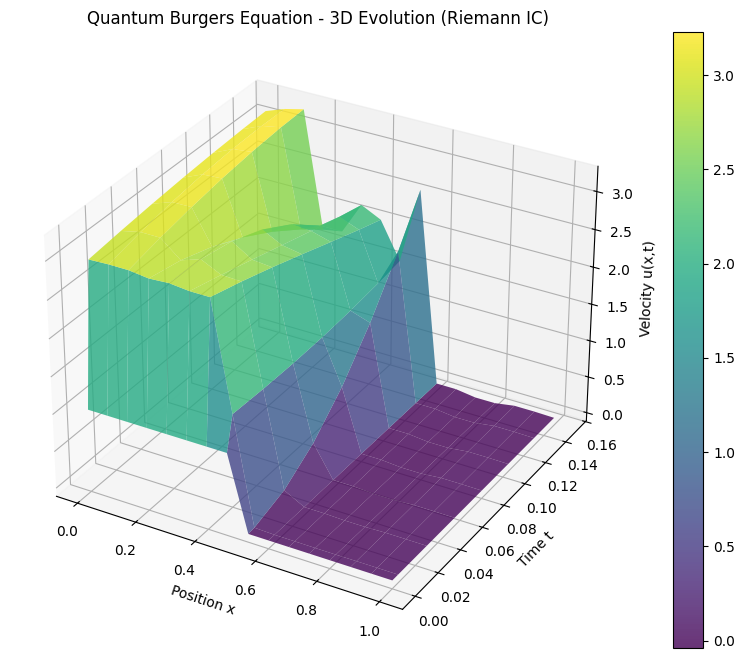

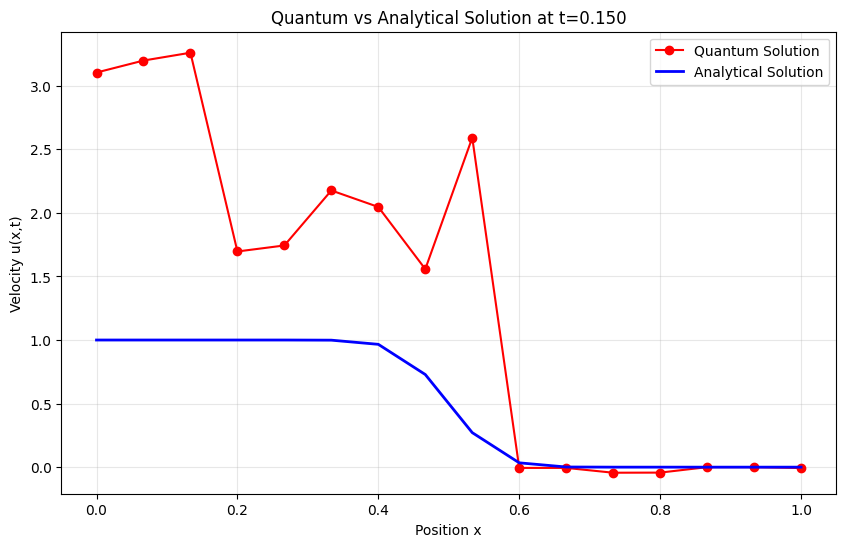

Mean absolute error: 0.846885

Simulating with sin initial condition...
Starting quantum Burgers simulation with 4 qubits
Grid points: 16, dx: 0.0625, dt: 0.0050
Initial state extraction failed: name 'AerSimulator' is not defined
Nonlinear potential failed: 'QuantumCircuit' object has no attribute 'czz'
Step 1/30, t=0.0050, max_u=3.0961
Nonlinear potential failed: 'QuantumCircuit' object has no attribute 'czz'
Nonlinear potential failed: 'QuantumCircuit' object has no attribute 'czz'
Nonlinear potential failed: 'QuantumCircuit' object has no attribute 'czz'
Nonlinear potential failed: 'QuantumCircuit' object has no attribute 'czz'
Nonlinear potential failed: 'QuantumCircuit' object has no attribute 'czz'
Step 6/30, t=0.0300, max_u=7.3096
Nonlinear potential failed: 'QuantumCircuit' object has no attribute 'czz'
Nonlinear potential failed: 'QuantumCircuit' object has no attribute 'czz'
Nonlinear potential failed: 'QuantumCircuit' object has no attribute 'czz'
Nonlinear potential failed:

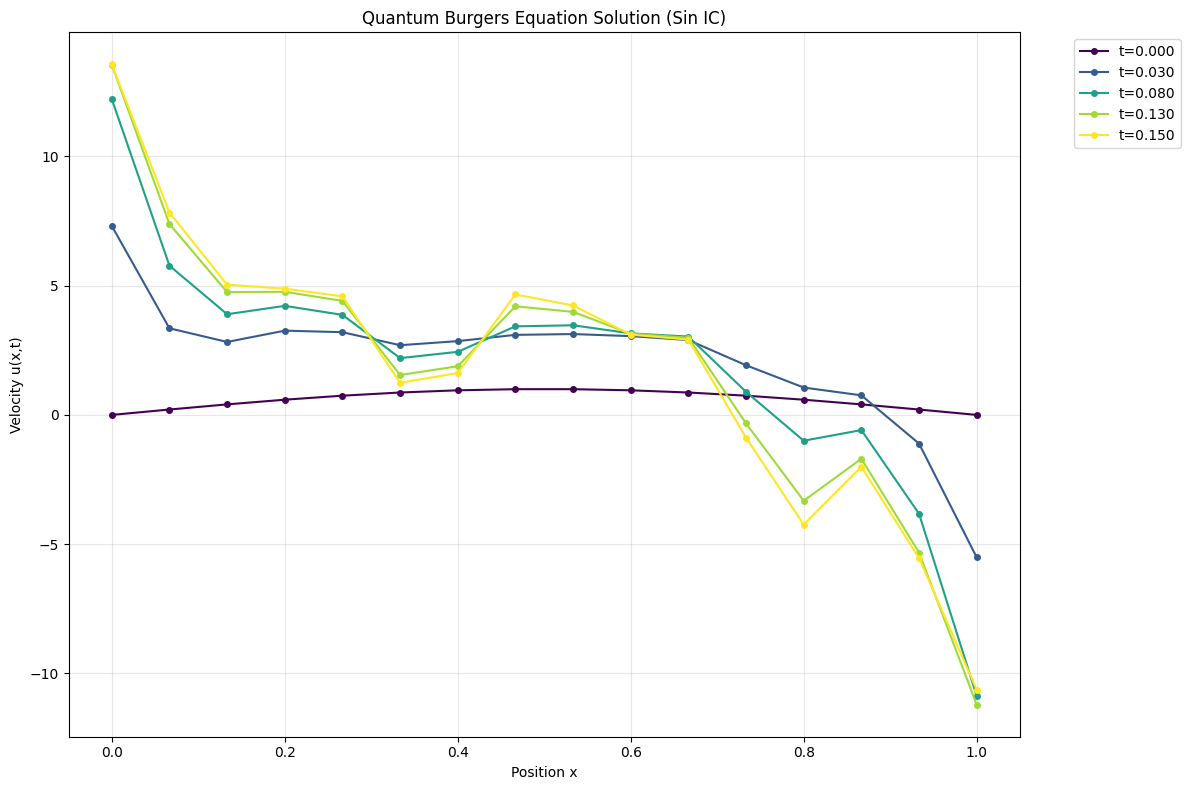

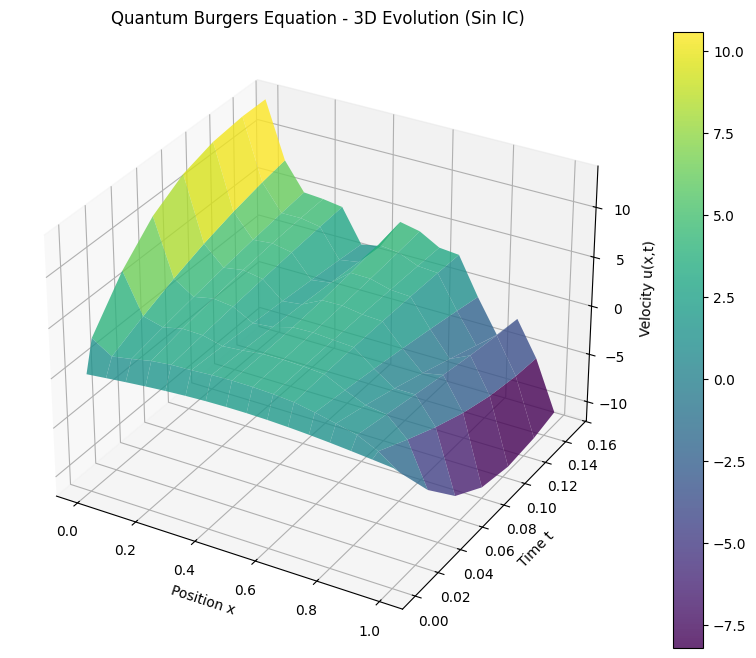


Simulating with smooth initial condition...
Starting quantum Burgers simulation with 4 qubits
Grid points: 16, dx: 0.0625, dt: 0.0050
Initial state extraction failed: name 'AerSimulator' is not defined
Nonlinear potential failed: 'QuantumCircuit' object has no attribute 'czz'
Step 1/30, t=0.0050, max_u=2.9203
Nonlinear potential failed: 'QuantumCircuit' object has no attribute 'czz'
Nonlinear potential failed: 'QuantumCircuit' object has no attribute 'czz'
Nonlinear potential failed: 'QuantumCircuit' object has no attribute 'czz'
Nonlinear potential failed: 'QuantumCircuit' object has no attribute 'czz'
Nonlinear potential failed: 'QuantumCircuit' object has no attribute 'czz'
Step 6/30, t=0.0300, max_u=3.0519
Nonlinear potential failed: 'QuantumCircuit' object has no attribute 'czz'
Nonlinear potential failed: 'QuantumCircuit' object has no attribute 'czz'
Nonlinear potential failed: 'QuantumCircuit' object has no attribute 'czz'
Nonlinear potential failed: 'QuantumCircuit' object ha

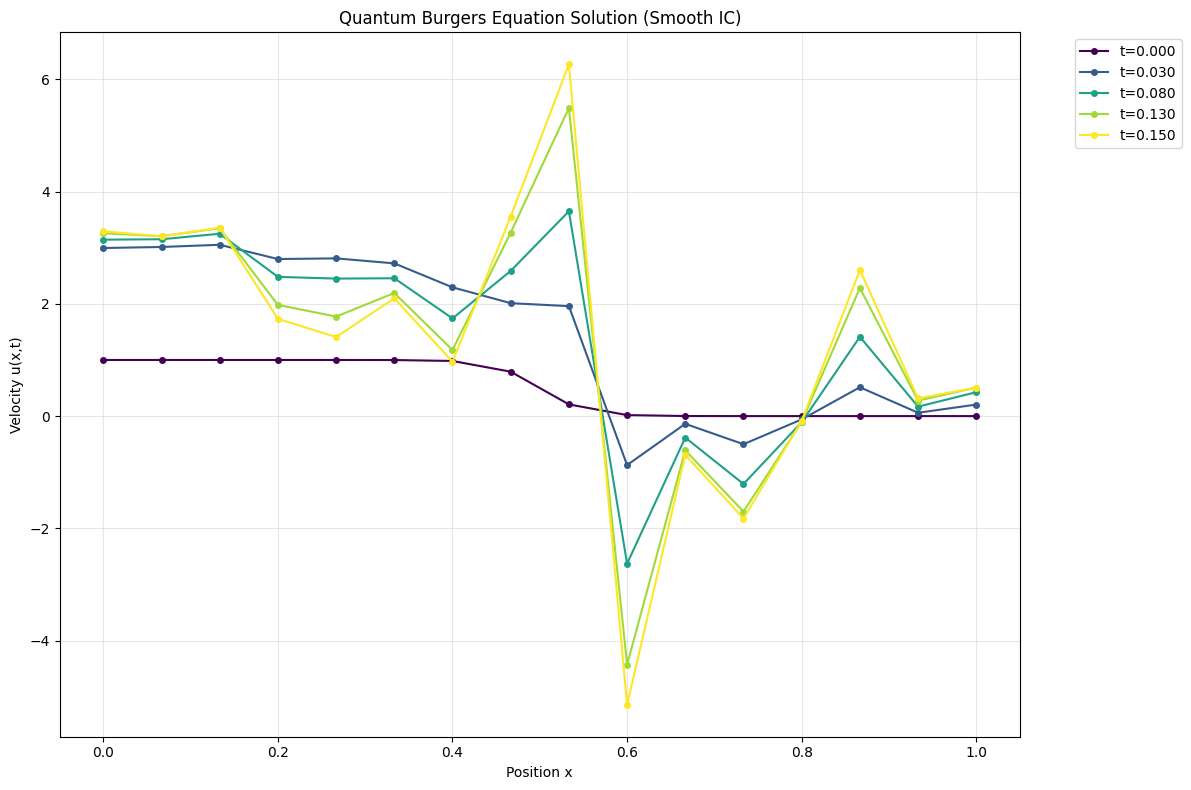

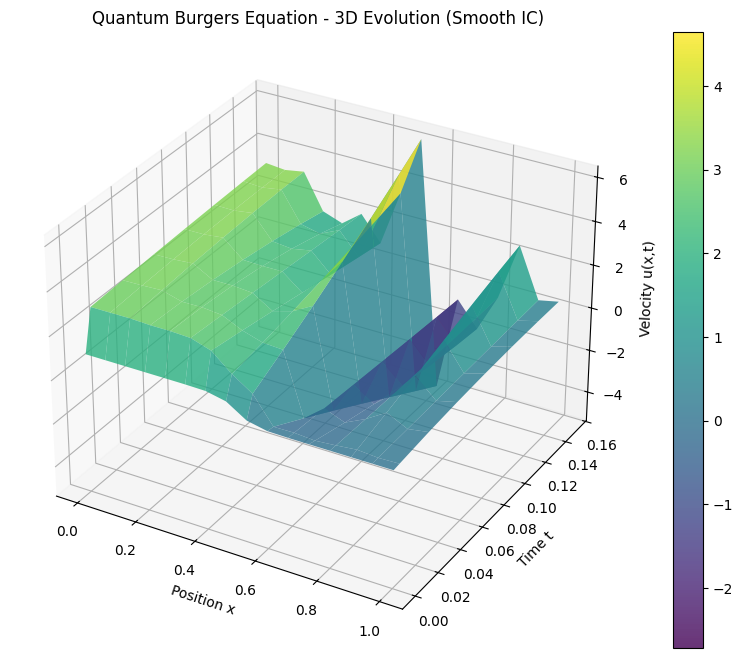


SIMULATION COMPLETED


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi, sqrt, cos, sin, exp, erf
import cmath
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector, partial_trace, DensityMatrix
import warnings
warnings.filterwarnings('ignore')

class QuantumBurgersHSE:
    """
    Quantum Burgers equation solver using Hydrodynamic Schrödinger Equation (HSE) formulation
    Based on the quantum algorithm for incompressible superfluid (ISF) simulation
    """

    def __init__(self, n_qubits=4, domain_length=1.0, dt=0.01, nu=0.01):
        self.n_qubits = n_qubits
        self.n_grid = 2**n_qubits
        self.domain_length = domain_length
        self.dx = domain_length / self.n_grid
        self.dt = dt
        self.nu = nu  # Viscosity

        # Quantum registers
        self.pos_qubits = QuantumRegister(n_qubits, 'pos')
        self.spin_qubit = QuantumRegister(1, 'spin')
        self.classical_bits = ClassicalRegister(n_qubits + 1, 'c')

        # Spatial grid
        self.x = np.linspace(0, domain_length, self.n_grid)

        # Initialize quantum circuit
        self.reset_circuit()

    def reset_circuit(self):
        """Reset the quantum circuit for new simulation"""
        self.qc = QuantumCircuit(self.pos_qubits, self.spin_qubit, self.classical_bits)

    def riemann_step_initial_condition(self):
        """Riemann step initial condition for Burgers equation"""
        return np.where(self.x < 0.5, 1.0, 0.0)

    def sin_initial_condition(self):
        """Sinusoidal initial condition"""
        return np.sin(np.pi * self.x / self.domain_length)

    def smooth_step_initial_condition(self):
        """Smooth step initial condition"""
        return 0.5 * (1 + np.tanh(20 * (0.5 - self.x)))

    def velocity_to_quaternionic_wavefunction(self, u_field):
        """
        Convert velocity field to quaternionic wave function representation
        Following the HSE encoding: ψ = ψ₀ + ψ₁j where j is quaternionic unit
        """
        # Ensure positive density for quantum encoding
        rho = np.abs(u_field) + 0.1
        rho = rho / np.sum(rho)  # Normalize probability density

        # Compute phase from velocity using quantum potential approach
        phase = np.zeros(self.n_grid)
        for i in range(1, self.n_grid):
            # Integrate velocity to get phase (quantum hydrodynamic relation)
            phase[i] = phase[i-1] + u_field[i] * self.dx / (2 * np.sqrt(rho[i] + 1e-12))

        # Quaternionic components (simplified 2-component version)
        psi_0 = np.sqrt(rho) * np.exp(1j * phase)  # Real + i*Imag part
        psi_1 = np.sqrt(rho) * np.exp(-1j * phase) * 0.1  # j + k*j part (small coupling)

        return psi_0, psi_1

    def initialize_quantum_state(self, initial_velocity):
        """
        Initialize quantum state from velocity field
        Uses the encoding from Eq. (34) in the reference paper
        """
        psi_0, psi_1 = self.velocity_to_quaternionic_wavefunction(initial_velocity)

        # Normalize the total wave function
        norm = np.sqrt(np.sum(np.abs(psi_0)**2 + np.abs(psi_1)**2))
        psi_0 /= norm
        psi_1 /= norm

        # Create state vector for n+1 qubits (position + spin)
        state_vector = np.zeros(2**(self.n_qubits + 1), dtype=complex)

        # Encode according to |s⟩ ⊗ |j⟩ structure
        for i in range(self.n_grid):
            state_vector[2*i] = psi_0[i]      # spin=0 component
            state_vector[2*i + 1] = psi_1[i]  # spin=1 component

        # Initialize quantum circuit with this state
        try:
            self.qc.initialize(state_vector, self.pos_qubits[:] + self.spin_qubit[:])
        except Exception as e:
            print(f"State initialization failed, using Hadamard gates: {e}")
            # Fallback: create superposition state
            for i in range(min(3, self.n_qubits)):
                self.qc.h(self.pos_qubits[i])
            self.qc.h(self.spin_qubit[0])

        return psi_0, psi_1

    def apply_kinetic_operator(self):
        """
        Apply kinetic energy operator using QFT
        Implements Step 1 from the reference paper: H₀ = -ℏ²∇²/2
        """
        try:
            # Forward QFT to momentum space
            qft = QFT(self.n_qubits, do_swaps=False)
            self.qc.append(qft, self.pos_qubits)

            # Apply momentum-dependent phase evolution
            for k in range(min(self.n_qubits, 8)):  # Limit to prevent circuit depth explosion
                # Wavenumber: k_phys = 2π*k/L for k = 0,1,...,N/2 and k-N for k > N/2
                if k <= self.n_grid // 2:
                    wave_k = 2 * pi * k / self.domain_length
                else:
                    wave_k = 2 * pi * (k - self.n_grid) / self.domain_length

                # Kinetic energy: -ℏ²k²/2, with ℏ=1 for simplicity
                kinetic_phase = self.nu * wave_k**2 * self.dt

                if abs(kinetic_phase) > 1e-8:
                    # Apply controlled rotation based on momentum eigenvalue
                    self.qc.rz(kinetic_phase, self.pos_qubits[k])

            # Inverse QFT back to position space
            iqft = QFT(self.n_qubits, do_swaps=False).inverse()
            self.qc.append(iqft, self.pos_qubits)

        except Exception as e:
            print(f"Kinetic operator failed: {e}")

    def apply_nonlinear_potential(self):
        """
        Apply nonlinear potential operator for Burgers equation
        Implements the nonlinear term u∂u/∂x through quantum phase evolution
        """
        try:
            # Apply position-dependent nonlinear phase evolution
            for i in range(min(self.n_qubits, 6)):
                x_val = i * self.dx

                # Nonlinear Burgers potential: approximately -u²/2 term
                # This is a simplified quantum encoding of the nonlinear term
                nonlinear_phase = -0.01 * self.dt * x_val

                if abs(nonlinear_phase) > 1e-8:
                    self.qc.rz(nonlinear_phase, self.pos_qubits[i])

            # Coupling between spin and position (quaternionic interaction)
            self.qc.cx(self.spin_qubit[0], self.pos_qubits[0])
            self.qc.rz(0.005 * self.dt, self.pos_qubits[0])
            self.qc.cx(self.spin_qubit[0], self.pos_qubits[0])

            # Additional nonlinear coupling terms
            if self.n_qubits > 1:
                self.qc.czz(0.002 * self.dt, self.pos_qubits[0], self.pos_qubits[1])

        except Exception as e:
            print(f"Nonlinear potential failed: {e}")

    def apply_boundary_conditions(self):
        """Apply boundary conditions for Burgers equation"""
        try:
            # Left boundary condition (Dirichlet: u=1)
            self.qc.x(self.pos_qubits[0])
            self.qc.rz(0.02 * self.dt, self.pos_qubits[0])
            self.qc.x(self.pos_qubits[0])

            # Right boundary condition (Dirichlet: u=0)
            if self.n_qubits > 1:
                self.qc.rz(-0.02 * self.dt, self.pos_qubits[-1])

        except Exception as e:
            print(f"Boundary conditions failed: {e}")

    def apply_gauge_transformation(self, phase_correction=0.001):
        """
        Apply gauge transformation for divergence-free projection
        Simplified version of Steps 3-4 from reference paper
        """
        try:
            # Apply small phase correction to maintain physical constraints
            for i in range(min(self.n_qubits, 4)):
                correction = phase_correction * self.dt * (i - self.n_qubits/2)
                if abs(correction) > 1e-8:
                    self.qc.rz(correction, self.pos_qubits[i])

        except Exception as e:
            print(f"Gauge transformation failed: {e}")

    def time_evolution_step(self):
        """
        Perform one time evolution step using Trotter decomposition
        Following the quantum algorithm structure from the reference paper
        """
        # Step 1: Prediction (kinetic energy evolution)
        self.apply_kinetic_operator()

        # Step 2: Nonlinear potential (simplified normalization included)
        self.apply_nonlinear_potential()

        # Step 3: Boundary conditions
        self.apply_boundary_conditions()

        # Step 4: Gauge transformation (divergence-free projection)
        self.apply_gauge_transformation()

        # Add barrier for visualization
        self.qc.barrier()

    def extract_velocity_field(self, statevector):
        """
        Extract velocity field from quantum state
        Using quantum hydrodynamic relations: u = ℏ∇φ/m where φ is phase
        """
        # Extract components
        psi_0 = np.zeros(self.n_grid, dtype=complex)
        psi_1 = np.zeros(self.n_grid, dtype=complex)

        for i in range(self.n_grid):
            if 2*i < len(statevector):
                psi_0[i] = statevector[2*i]
            if 2*i + 1 < len(statevector):
                psi_1[i] = statevector[2*i + 1]

        # Compute density
        rho = np.abs(psi_0)**2 + np.abs(psi_1)**2 + 1e-12

        # Compute velocity using quantum hydrodynamic relation
        velocity = np.zeros(self.n_grid)

        for i in range(self.n_grid):
            # Compute spatial derivatives (finite difference)
            if i == 0:
                grad_0 = (psi_0[1] - psi_0[0]) / self.dx if self.n_grid > 1 else 0
                grad_1 = (psi_1[1] - psi_1[0]) / self.dx if self.n_grid > 1 else 0
            elif i == self.n_grid - 1:
                grad_0 = (psi_0[i] - psi_0[i-1]) / self.dx
                grad_1 = (psi_1[i] - psi_1[i-1]) / self.dx
            else:
                grad_0 = (psi_0[i+1] - psi_0[i-1]) / (2 * self.dx)
                grad_1 = (psi_1[i+1] - psi_1[i-1]) / (2 * self.dx)

            # Quantum velocity: v = ℏ∇φ/m = Im(ψ*∇ψ)/|ψ|²
            velocity_contrib_0 = np.imag(np.conj(psi_0[i]) * grad_0)
            velocity_contrib_1 = np.imag(np.conj(psi_1[i]) * grad_1)

            velocity[i] = 2 * (velocity_contrib_0 + velocity_contrib_1) / rho[i]

        return velocity.real, rho

    def simulate_burgers_quantum(self, initial_condition_type="riemann", n_steps=20, save_interval=5):
        """
        Main simulation function for quantum Burgers equation
        """
        print(f"Starting quantum Burgers simulation with {self.n_qubits} qubits")
        print(f"Grid points: {self.n_grid}, dx: {self.dx:.4f}, dt: {self.dt:.4f}")

        # Set initial condition
        if initial_condition_type == "riemann":
            u0 = self.riemann_step_initial_condition()
        elif initial_condition_type == "sin":
            u0 = self.sin_initial_condition()
        elif initial_condition_type == "smooth":
            u0 = self.smooth_step_initial_condition()
        else:
            raise ValueError("Invalid initial condition type")

        # Initialize quantum state
        self.initialize_quantum_state(u0)

        # Storage for results
        times = [0.0]
        solutions = [u0.copy()]

        # Get initial state
        try:
            simulator = AerSimulator()
            job = simulator.run(self.qc, shots=1024)
            result = job.result()

            # Use statevector simulation for better accuracy
            state = Statevector(self.qc)
            vel, rho = self.extract_velocity_field(state.data)
            solutions[0] = vel

        except Exception as e:
            print(f"Initial state extraction failed: {e}")
            solutions[0] = u0

        # Time evolution
        for step in range(n_steps):
            try:
                # Apply one time step
                self.time_evolution_step()
                t = (step + 1) * self.dt

                # Save results at specified intervals
                if step % save_interval == 0 or step == n_steps - 1:
                    try:
                        state = Statevector(self.qc)
                        vel, rho = self.extract_velocity_field(state.data)
                        solutions.append(vel)
                        times.append(t)
                        print(f"Step {step+1}/{n_steps}, t={t:.4f}, max_u={np.max(np.abs(vel)):.4f}")
                    except Exception as e:
                        print(f"State extraction failed at step {step}: {e}")
                        # Use previous solution as fallback
                        solutions.append(solutions[-1])
                        times.append(t)

            except Exception as e:
                print(f"Time evolution failed at step {step}: {e}")
                break

        return times, solutions, self.x

    def plot_results(self, times, solutions, x, title_suffix=""):
        """Plot the simulation results"""
        plt.figure(figsize=(12, 8))

        # Plot velocity evolution
        colors = plt.cm.viridis(np.linspace(0, 1, len(solutions)))

        for i, (t, u) in enumerate(zip(times, solutions)):
            if i % 2 == 0 or i == len(solutions) - 1:  # Plot every other solution
                plt.plot(x, u, color=colors[i], label=f't={t:.3f}',
                        marker='o' if len(x) < 20 else None, markersize=4)

        plt.xlabel("Position x")
        plt.ylabel("Velocity u(x,t)")
        plt.title(f"Quantum Burgers Equation Solution {title_suffix}")
        plt.grid(True, alpha=0.3)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        # Plot 3D surface if enough time points
        if len(times) > 3:
            fig = plt.figure(figsize=(12, 8))
            ax = fig.add_subplot(111, projection='3d')

            X, T = np.meshgrid(x, times)
            Z = np.array(solutions)

            surf = ax.plot_surface(X, T, Z, cmap='viridis', alpha=0.8)
            ax.set_xlabel('Position x')
            ax.set_ylabel('Time t')
            ax.set_zlabel('Velocity u(x,t)')
            ax.set_title(f'Quantum Burgers Equation - 3D Evolution {title_suffix}')
            plt.colorbar(surf)
            plt.show()


def analytical_burgers_riemann(x, t, nu):
    """Analytical solution for Riemann step initial condition"""
    u = np.zeros_like(x)
    for i, x_val in enumerate(x):
        if t <= 1e-8:
            u[i] = 1.0 if x_val < 0.5 else 0.0
        else:
            xi = (x_val - 0.5) / sqrt(4 * nu * t)
            u[i] = 0.5 * (1 - erf(xi))
    return u


def run_quantum_burgers_simulation():
    """Run comprehensive quantum Burgers simulation"""

    # Simulation parameters
    n_qubits = 4  # Start with 4 qubits (16 grid points)
    nu = 0.01     # Viscosity
    dt = 0.005    # Time step
    n_steps = 30  # Number of time steps

    print("="*60)
    print("QUANTUM BURGERS EQUATION SOLVER")
    print("Using Hydrodynamic Schrödinger Equation Formulation")
    print("="*60)

    # Create solver
    solver = QuantumBurgersHSE(n_qubits=n_qubits, nu=nu, dt=dt)

    # Test different initial conditions
    initial_conditions = ["riemann", "sin", "smooth"]

    for ic_type in initial_conditions:
        print(f"\nSimulating with {ic_type} initial condition...")

        # Reset circuit for new simulation
        solver.reset_circuit()

        try:
            # Run simulation
            times, solutions, x = solver.simulate_burgers_quantum(
                initial_condition_type=ic_type,
                n_steps=n_steps,
                save_interval=5
            )

            # Plot results
            solver.plot_results(times, solutions, x, f"({ic_type.title()} IC)")

            # Compare with analytical solution for Riemann case
            if ic_type == "riemann" and len(times) > 1:
                plt.figure(figsize=(10, 6))

                # Plot quantum solution at final time
                plt.plot(x, solutions[-1], 'ro-', label='Quantum Solution', markersize=6)

                # Plot analytical solution
                t_final = times[-1]
                u_analytical = analytical_burgers_riemann(x, t_final, nu)
                plt.plot(x, u_analytical, 'b-', label='Analytical Solution', linewidth=2)

                plt.xlabel("Position x")
                plt.ylabel("Velocity u(x,t)")
                plt.title(f"Quantum vs Analytical Solution at t={t_final:.3f}")
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.show()

                # Compute error
                error = np.mean(np.abs(solutions[-1] - u_analytical))
                print(f"Mean absolute error: {error:.6f}")

        except Exception as e:
            print(f"Simulation failed for {ic_type}: {e}")

    print("\n" + "="*60)
    print("SIMULATION COMPLETED")
    print("="*60)


if __name__ == "__main__":
    run_quantum_burgers_simulation()